<a href="https://colab.research.google.com/github/rinrin528/AIFFEL-1st-Hackathon/blob/main/EDA/EDA%ED%86%B5%ED%95%A9%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 해커톤1. 레스토랑 방문자 수 예측하기

## 데이터셋: [Recruit Restaurant Visitor Forecasting | Kaggle](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/overview)



---



## 🔍문제 이해하기
-	a time-series forecasting problem
-	2개 사이트에서 얻은 데이터셋이다.
 - hpg (Hot Pepper Gourmet): 레스토랑을 찾거나 예약할 수 있는 사이트
 - air (AirReGI/Restaurant Borad): 예약 관리, 사전계산 가능한 사이트
-	훈련데이터는 **2016년부터 2017년4월**까지, 테스트데이터는 **2016년 4월마지막주부터 5월**동안의 데이터이다. <br> (테스트데이터는 의도적으로 휴가철 데이터를 설정하였다.)
-	테스트셋에서 레스토랑이 닫거나 방문자가 없는 날은 scoring되지 않는다. 훈련데이터셋에서는 레스토랑이 닫은 날은 생략했다.



---




## 📊데이터셋 이해하기 (8개)

**1.	air_reserve:** air사이트에서 이뤄진 예약들<br>
- 칼럼) air_store_id, visit_datetime(방문시각), reserve_datetime(예약시각), reserve_visitors(예약방문자수)

**2.	hpg_reserve:** hpg사이트에서 이뤄진 예약들<br>
- 칼럼) hpg_store_id, visit_datetime, reserve_datetime, reserve_visitors<br>

**3.	air_store_info:** air사이트의 레스토랑 정보<br>
- 칼럼) air_store_id, air_genre_name(레스토랑종류), air_area_name(지역구이름), latitude(위도), longitude(경도)<br>

**4.	hpg_store_info:** hpg사이트의 레스토랑 정보<br>
- 칼럼) hpg_store_id, hpg_genre_name, hpg_area_name, latitude, longitude<br>

**5.	store_id_relation**<br>
- 칼럼) hpg_store_id, air_store_id<br>

**6.	air_visit_data**: air레스토랑들의 방문이력을 보여준다.
- **training 데이터**
- 칼럼) air_store_id, visit_date, **visitors(방문자수)**

**7.	sample_submission:** 우리가 예측해야하는 정답과 정답의 포맷을 보여준다.
- **test 데이터**
- 칼럼) id, **visitors(방문자수)**

**8.	date_info**: 데이터셋의 날짜 관련 기본정보를 제공한다.<br>
- 칼럼) calendar_date(날짜), day_of_week(요일), holiday_fig(일본의 휴일)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 분석 및 모델 학습 라이브러리
import numpy as np
import pandas as pd
from sklearn import ensemble, neighbors, linear_model, metrics, preprocessing
from datetime import datetime
import glob, re
import time, datetime
from datetime import timedelta

# 시각화 라이브러리
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

data = {
    'tra': pd.read_csv('/content/drive/MyDrive/data/air_visit_data.csv'),
    'as': pd.read_csv('/content/drive/MyDrive/data/air_store_info.csv'),
    'hs': pd.read_csv('/content/drive/MyDrive/data/hpg_store_info.csv'),
    'ar': pd.read_csv('/content/drive/MyDrive/data/air_reserve.csv'),
    'hr': pd.read_csv('/content/drive/MyDrive/data/hpg_reserve.csv'),
    'id': pd.read_csv('/content/drive/MyDrive/data/store_id_relation.csv'),
    'tes': pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv'),
    'hol': pd.read_csv('/content/drive/MyDrive/data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

print('[----Data structure----]')
print('Training data:\t\t',data['tra'].shape, '\tunique store id: ',len(data['tra']['air_store_id'].unique()))
print('Id data:\t\t',data['id'].shape)
print('Air store data:\t\t',data['as'].shape,'\tunique store id: ',data['as']['air_store_id'].unique().shape)
print('Hpg store data:\t\t',data['hs'].shape,'\tunique store id: ',data['hs']['hpg_store_id'].unique().shape)
print('Air reserve data:\t',data['ar'].shape,'\tunique store id: ',data['ar']['air_store_id'].unique().shape)
print('Hpg reserve data:\t',data['hr'].shape,'\tunique store id: ',data['hr']['hpg_store_id'].unique().shape)

data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])        # hpg reserve data
data['hs'] = pd.merge(data['hs'], data['id'], how='inner', on=['hpg_store_id'])   

for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date

    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    

    # (방문날짜 - 예약날짜)를 'reserve_date_diff'칼럼에 저장하고
    # air store id와 방문날짜를 기준으로 그룹화한다.
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[
            'reserve_datetime_diff', 'reserve_visitors'
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'
        })

data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])    # 날짜 데이터타입으로 변경
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek              # 요일 컬럼 생성  (정수 0~6)
data['tra']['dow_name'] = data['tra']['visit_date'].dt.day_name()        # 요일명 컬럼 생성 (Monday ~ Sunday)
data['tra']['year'] = data['tra']['visit_date'].dt.year                  # 년도 컬럼 생성
data['tra']['month'] = data['tra']['visit_date'].dt.month                # month 컬럼 생성

data['tra']['visit_date'] = data['tra']['visit_date'].dt.date
data['tra']['year_mth'] = data['tra']['year'].astype(str)+'-'+data['tra']['month'].astype(str)    # 연도-월 형태로 저장

[----Data structure----]
Training data:		 (252108, 3) 	unique store id:  829
Id data:		 (150, 2)
Air store data:		 (829, 5) 	unique store id:  (829,)
Hpg store data:		 (4690, 5) 	unique store id:  (4690,)
Air reserve data:	 (92378, 4) 	unique store id:  (314,)
Hpg reserve data:	 (2000320, 4) 	unique store id:  (13325,)


# ✨시각화

## data1. air_visit_data

### 1) 일일 방문자 수
일별 편차는 꾸준히 존재하며, 2016년 7월 ~ 2016년 12월에 일일 방문자 수가 전체적으로 확연히 크다.<br>
반면 2016년 1월 ~ 2016년 6월 사이의 방문자 수가 전체적으로 작다.

Text(0.5, 1.0, 'Visitors per Day')

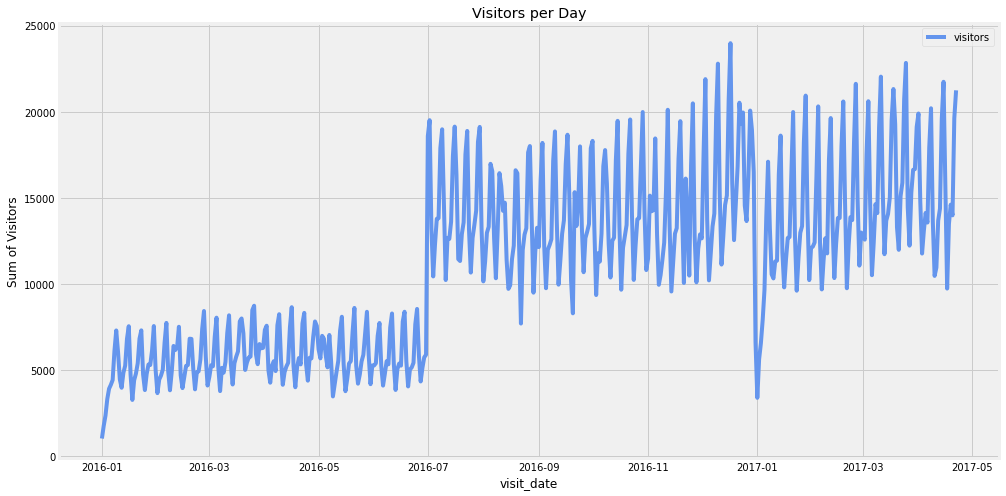

In [ ]:
f,ax = plt.subplots(1,1,figsize=(15,8))

plt1 = data['tra'].groupby(['visit_date'], as_index=False).agg({'visitors': np.sum})   # 방문날짜를 기준으로 묶어서 방문자 수를 더한값
plt1=plt1.set_index('visit_date')
plt1.plot(color='cornflowerblue', kind='line', ax=ax)

plt.ylabel("Sum of Visitors")
plt.title("Visitors per Day")

### 2) 요일별 평균 방문자 수

In [ ]:
df = data['tra'].groupby('dow_name').mean().drop(['year', 'month', 'dow'], axis=1)
order_dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df.reindex(index=order)

,visitors
dow_name,
Monday,17.177009
Tuesday,17.672137
Wednesday,19.230121
Thursday,18.922702
Friday,23.072737
Saturday,26.313688
Sunday,23.873362


토요일에 방문하는 손님이 제일 많다.<br>
금토일이 나머지 요일보다 비교적 방문자가 많다.

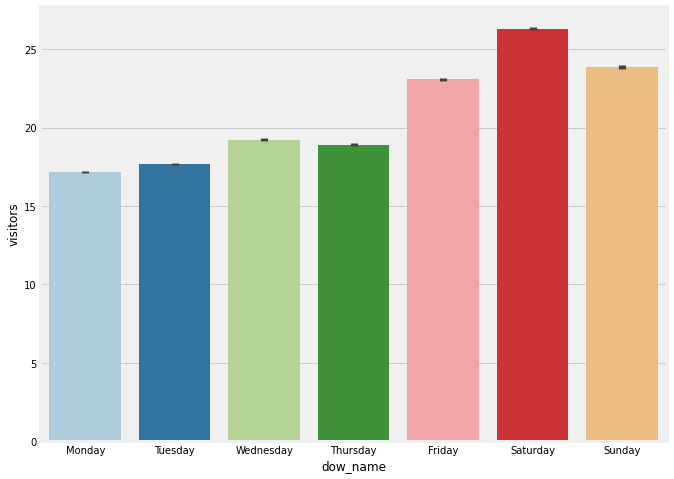

In [ ]:
fig = plt.figure(figsize=(10,8))

sns.barplot(x='dow_name', y='visitors', data=data['tra'], order=order_dow, palette="Paired")

### 3) 방문자 수 빈도 
R의 ggplot을 라이브러리를 통해 파이썬에서 사용할 수 있다.


[[Python] Python에서 R ggplot2 함수로 그래프 그리기 (by PlotNine library)](https://rfriend.tistory.com/420)

In [ ]:
print(data['tra']['visitors'].max())
print(data['tra']['visitors'].mean())

877
20.973761245180636


<Figure size 432x288 with 0 Axes>

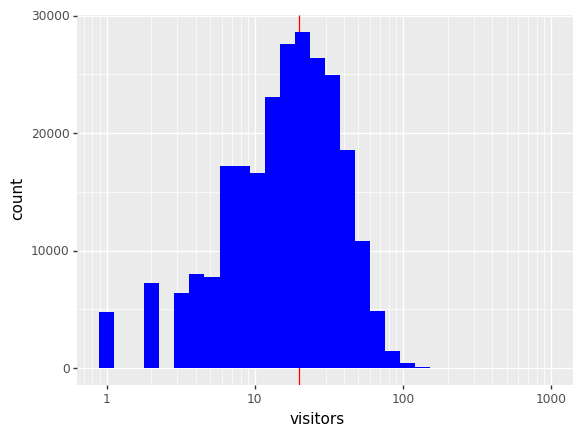

<ggplot: (8760694243177)>

In [ ]:
from plotnine import *

fig = plt.figure()

ggplot(data['tra'], aes('visitors')) +\
  geom_vline(xintercept = 20, color = 'red') +\
  geom_histogram(fill = 'blue', bins = 30) +\
  scale_x_log10()

## 추가로 요일별 장르에 따른 방문자수 
## 요일에 따른? 공휴일과 아닌날? reserve_datetime_diff 값 시각화하기
## hpg_reserve 시각화하기

### 4) 방문일자 별 방문자수

Text(0.5, 1.0, 'Visitors per Day')

<Figure size 3600x2160 with 0 Axes>

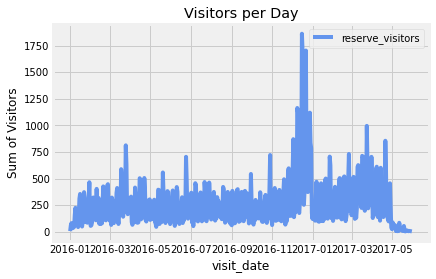

In [ ]:
fig = plt.figure(figsize=(50,30))

plt1 = data['hr'].groupby(['visit_date'], as_index=False).agg({'reserve_visitors': np.sum})   # 방문날짜를 기준으로 묶어서 방문자 수를 더한값
plt1=plt1.set_index('visit_date')
plt1.plot(color='cornflowerblue', kind='line')

plt.ylabel("Sum of Visitors")
plt.title("Visitors per Day")

### 5) 위도, 경도 기준 가게 분포

In [ ]:
import folium
from folium import plugins

location =stores.groupby(['latitude', 'longitude']).size().reset_index()
locationheat = location[['latitude', 'longitude']]
locationheat = locationheat.values.tolist()

map1 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Watercolor",# width=1000, height=500,
                        zoom_start = 5)
heatmap=plugins.HeatMap(locationheat).add_to(map1)
map1

### 6) 장르별 가게 위치

In [ ]:
location =stores.groupby(['air_store_id','air_genre_name'])['latitude','longitude'].mean().reset_index()
locationlist = location[['latitude', 'longitude']]
locationlist = locationlist.values.tolist()
map2 = folium.Map(location=[39, 139], 
                        tiles = "Stamen Toner",# width=1000, height=500,
                        zoom_start = 5)
marker_cluster=plugins.MarkerCluster().add_to(map2)
for point in range(0, len(location)):
    folium.Marker(locationlist[point],
    icon=folium.Icon(color='white', icon_color='red', 
                     #icon='fa fa-info-circle',
                     icon='fa fa-circle-o-notch fa-spin',
                     angle=0, 
                     prefix='fa')).add_to(marker_cluster)
map2

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('husl',9)
%matplotlib inline

## data2. air_reserve

In [ ]:
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime'])  
    data[df]['hour']=data[df]['visit_datetime'].dt.hour
    data[df]['dow'] = data[df]['visit_datetime'].dt.dayofweek              # 요일 컬럼 생성  (정수 0~6)
    data[df]['dow_name'] = data[df]['visit_datetime'].dt.day_name()# 요일명 컬럼 생성 (Monday ~ Sunday)
    data[df]['year'] = data[df]['visit_datetime'].dt.year                  # 년도 컬럼 생성
    data[df]['month'] = data[df]['visit_datetime'].dt.month 
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1)
   

Text(0.5, 1.0, "'air' visit date")

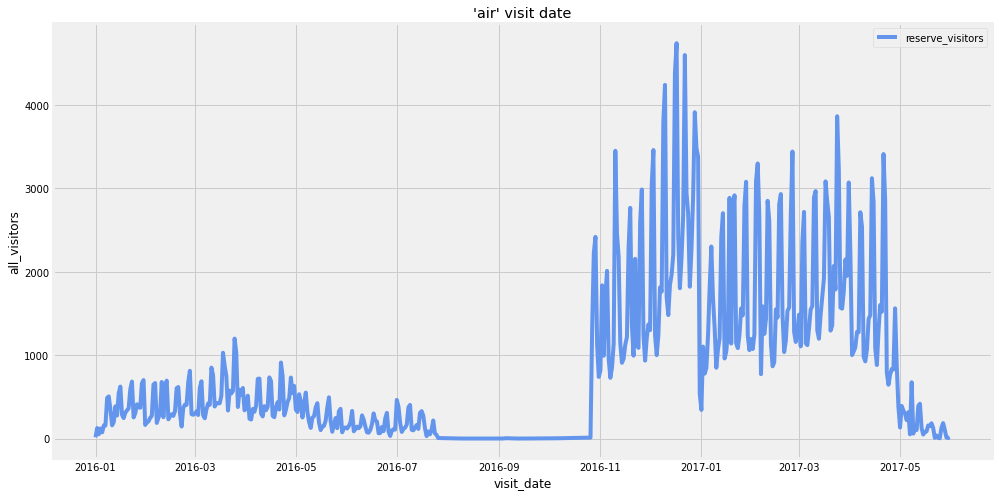

In [ ]:
f,ax = plt.subplots(1,1,figsize=(15,8))

plt1 = data['ar'].groupby(['visit_date'], as_index=False).agg({'reserve_visitors': np.sum})   # 방문날짜를 기준으로 묶어서 방문자 수를 더한값
plt1=plt1.set_index('visit_date')
plt1.plot(color='cornflowerblue', kind='line', ax=ax)

plt.ylabel("all_visitors")
plt.title("'air' visit date")

2016년의 예약은 많이 저조해보이고, 심지어 긴시간 없는 구간도 보인다. 16년 연말 동안만 예약이 늘었다.<br>
2017년의 고객수는 2016년에 비해 훨씬 많다.

In [ ]:
from plotnine import *

fig = plt.figure()

ggplot(data['tra'], aes('visitors')) +\
  geom_vline(xintercept = 20, color = 'red') +\
  geom_histogram(fill = 'blue', bins = 30) +\
  scale_x_log10()

## data4 & 5. air_store_info, hpg_store_info
- air에는 총 829개의 가게 정보가 존재한다.
- air는 총 14개의 종류로 식당을 분류하고 있다.
- air에서 포괄하고 있는 지역은 103개이다.
- hpg에는 총 4690개 점포가 입점되어 있다.
- hpg는 총 34개의 종류로 식당을 분류하고 있다.
- hpg에서 포괄하고 있는 지역은 129개이다.

In [ ]:
# 분석을 위해 다시 불러오기
data = {
    'tra': pd.read_csv('/content/drive/MyDrive/data/air_visit_data.csv'),
    'as': pd.read_csv('/content/drive/MyDrive/data/air_store_info.csv'),
    'hs': pd.read_csv('/content/drive/MyDrive/data/hpg_store_info.csv'),
    'ar': pd.read_csv('/content/drive/MyDrive/data/air_reserve.csv'),
    'hr': pd.read_csv('/content/drive/MyDrive/data/hpg_reserve.csv'),
    'id': pd.read_csv('/content/drive/MyDrive/data/store_id_relation.csv'),
    'tes': pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv'),
    'hol': pd.read_csv('/content/drive/MyDrive/data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

### 7) 장르별 가게 분포

- `air`에서는 이자카야, 카페가 타 장르에 비해 월등히 높다.
- `hpg`는 장르 중에서 유의미한 점포 개수를 보유하고 있는 장르 수가 10개 내외이다.
- 또한 전체 가게의 37%가 `Japanese Style`으로 구분되어서 `air_genre_name`에 비해 방문자와의 연관이 약할 가능성이 있다.

In [40]:
# 전체 가게 중 Japanese style의 비율
print(len(data['hs'][data['hs']['hpg_genre_name']=='Japanese style'])/len(data['hs']))

0.373134328358209


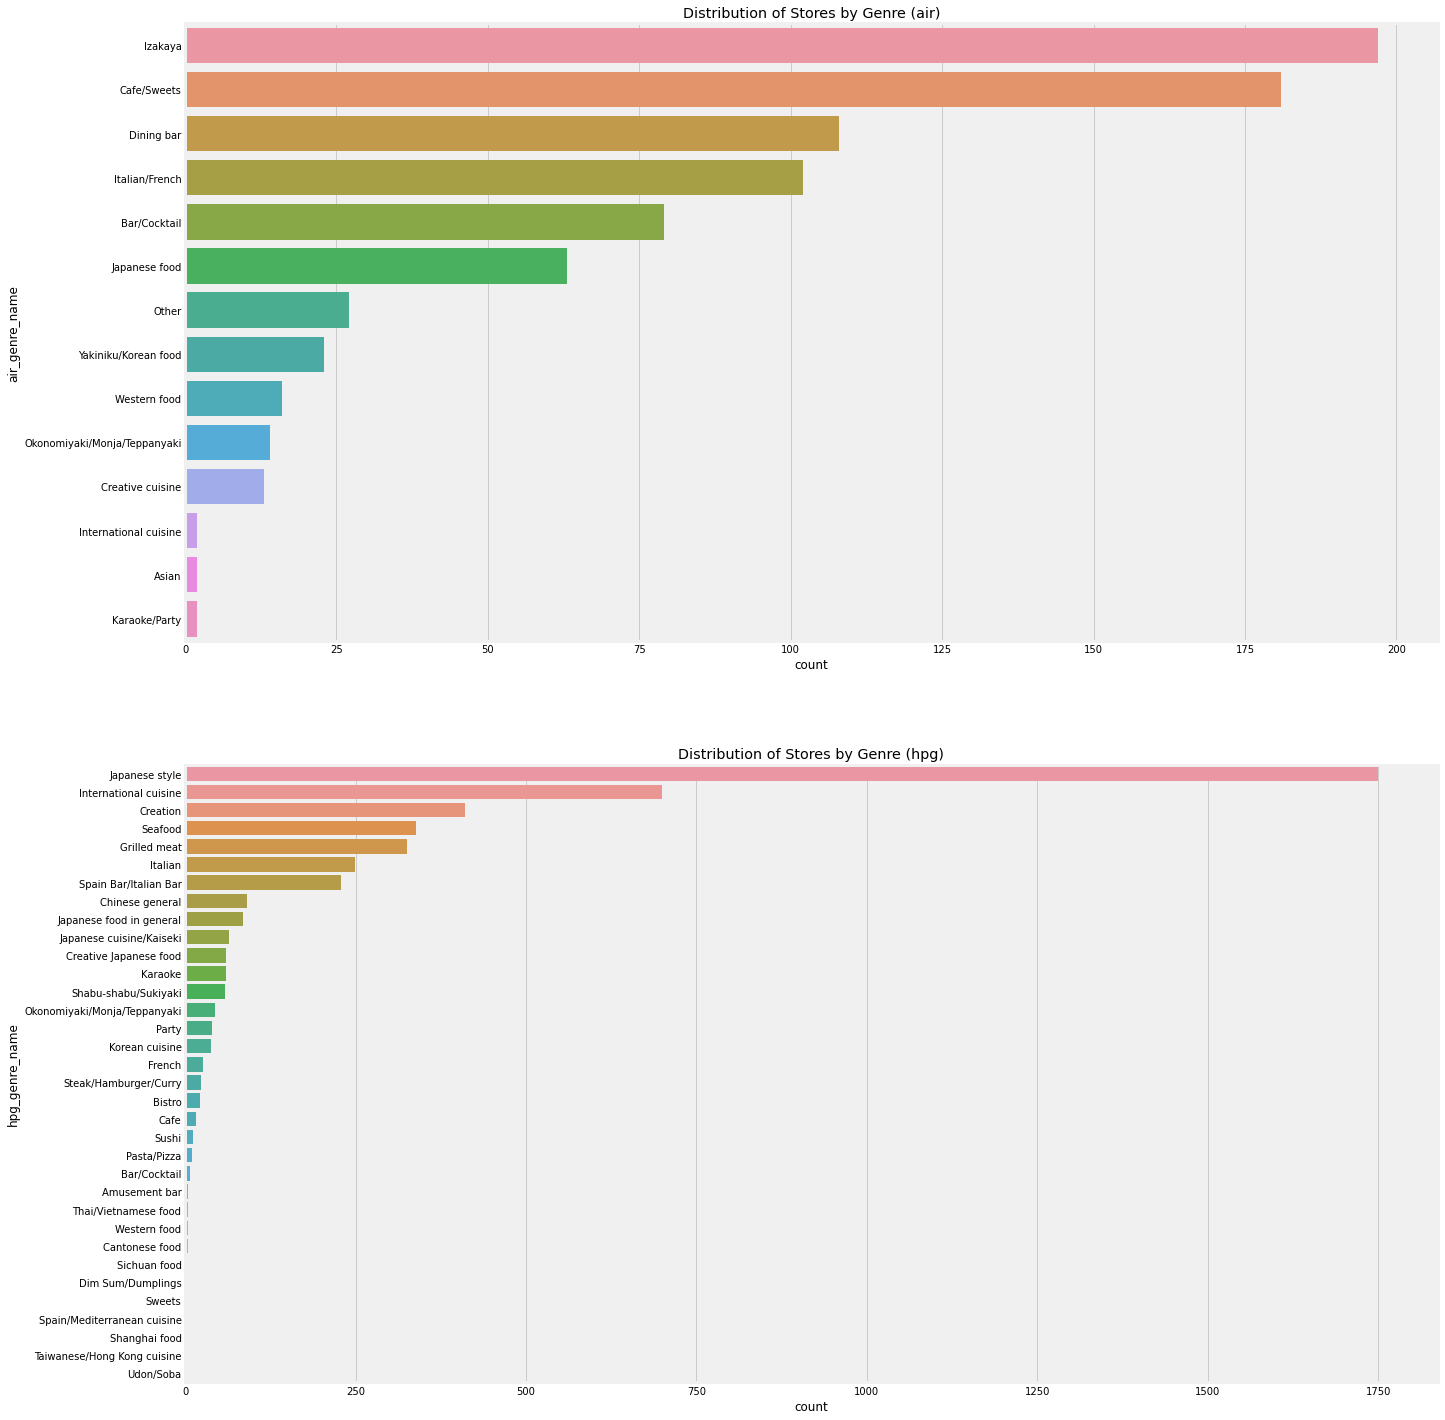

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,25))
sns.countplot(y=data['as']['air_genre_name'],
              order=data['as']['air_genre_name'].value_counts().index,ax=ax1)
sns.countplot(y=data['hs']['hpg_genre_name'],
              order=data['hs']['hpg_genre_name'].value_counts().index,ax=ax2)
ax1.set(title='Distribution of Stores by Genre (air)')
ax2.set(title='Distribution of Stores by Genre (hpg)')
plt.show()

### 8) 지역별 가게 분포
- 지역의 종류가 많으므로 상위 10개 지역에서의 분포와 더 넓은 행정구역 단위의 지역별 분포를 보자

- 단순 `air_area_name`으로만 보면 컬럼 수가 너무 많아서 한눈에 보기 어렵다.

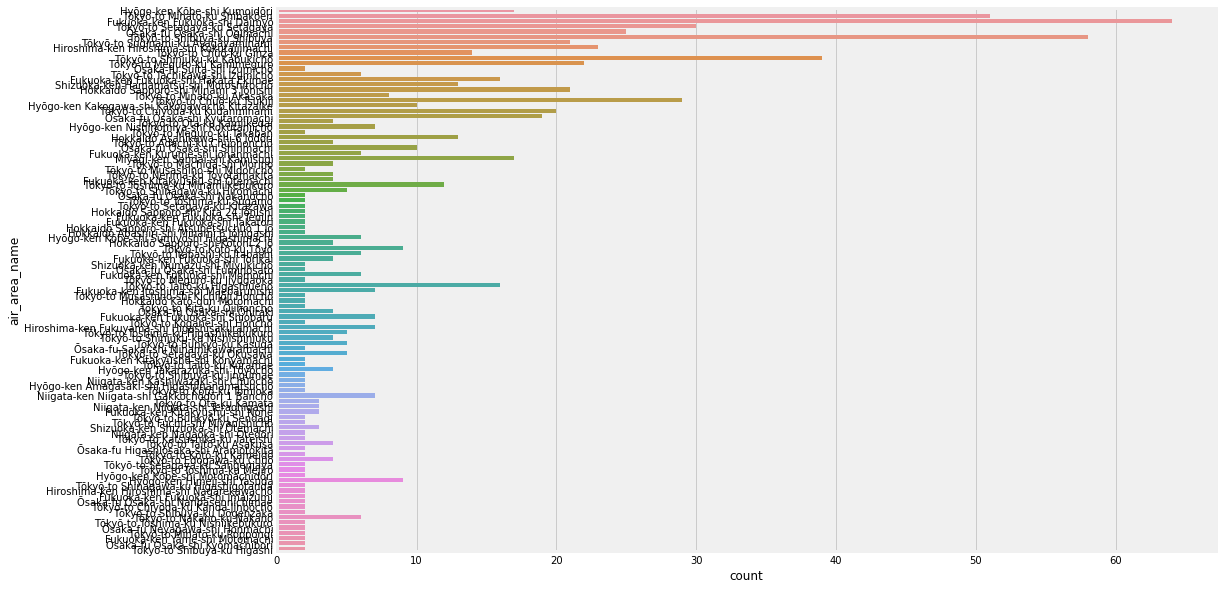

In [38]:
plt.figure(figsize=(15,10))
sns.countplot(y=data['as']['air_area_name'])
plt.show()

- `air_area_name`과 `hpg_area_name`은 도/도/부/현, 시/구, 동으로 구성되어 있다.
- 대단위, 중단위, 소단위 사이는 공백으로 구분되어있다.
- 우선 대단위로 그룹화해서 시각화해보자.

### 9) 도도부현별 가게 분포
- 도도부현 정보를 추출한 칼럼을 추가한다.

In [ ]:
for df, name in [('as','air'),('hs','hpg')]:
  data[df]['dodo'] = data[df][name+'_area_name'].apply(lambda x:x.split(' ')[0])

- air 입점 점포는 도쿄 지역의 가게가 월등히 많은 것을 알 수 있고 그 뒤를 후쿠오카와 오사카가 따르고 있다.
- hpg는 도쿄와 다른 지역의 차이가 air 보다 심하다.
- 그리고 후쿠오카와 오사카의 순위가 바뀌었다.
- 또한 air에서 보지 못했던 None이 발생했다.

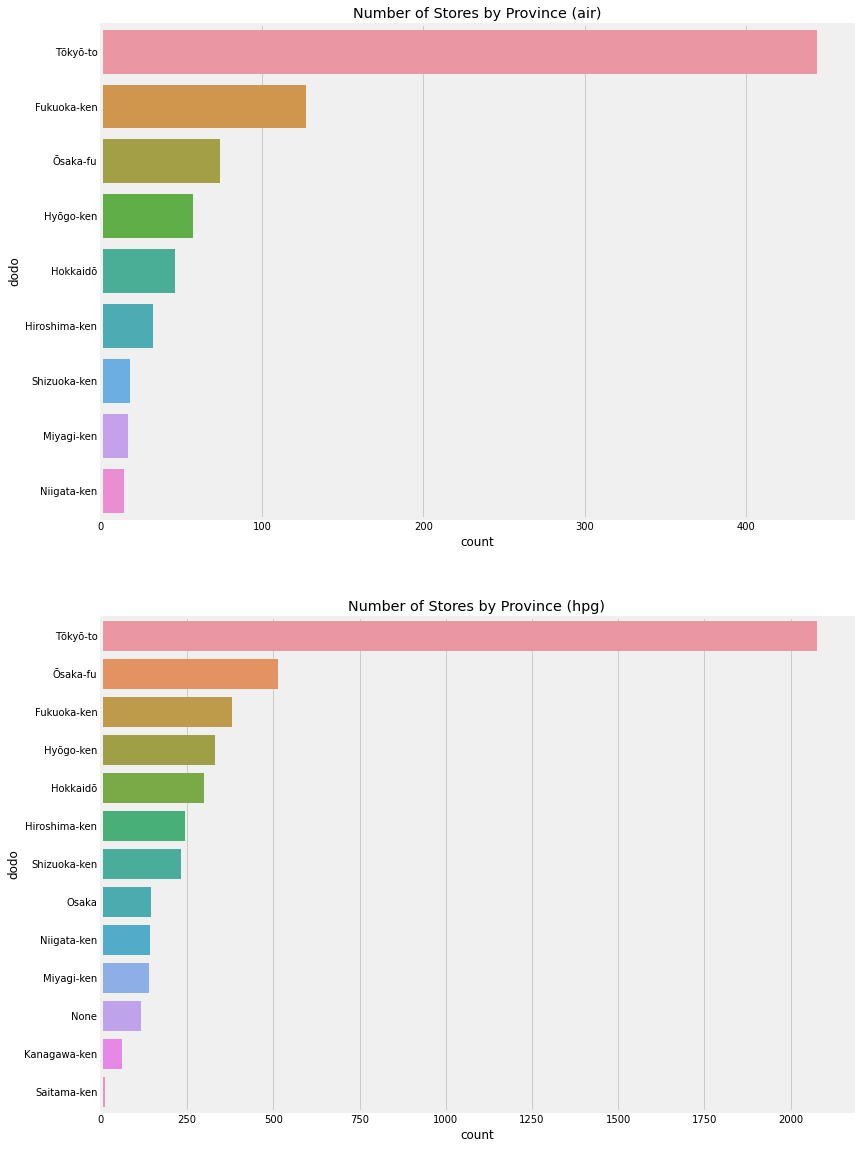

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,20))
sns.countplot(y=data['as']['dodo'],
             order=data['as']['dodo'].value_counts().index, ax=ax1)
sns.countplot(y=data['hs']['dodo'],
             order=data['hs']['dodo'].value_counts().index, ax=ax2)
ax1.set(title='Number of Stores by Province (air)')
ax2.set(title='Number of Stores by Province (hpg)')
plt.show()

- 실제 `hpg_area_name`, `latitude`, `longitude`가 None인 채 `store_id`만 있는 데이터가 117개 있었다.

In [43]:
data['hs'][data['hs']['dodo']=='None'].head(1)
len(data['hs'][data['hs']['dodo']=='None'])

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,dodo,sigu
651,hpg_5fea90674a2185a0,Japanese style,None None None,35.703381,139.660343,None,None None


117

### 10) 시구별 가게 분포
- 도도부현 - 시구의 정보까지 뽑아보자.

In [ ]:
for df, name in [('as','air'),('hs','hpg')]:
  data[df]['sigu']=data[df][name+'_area_name'].apply(lambda x:' '.join(x.split(' ')[:2]))

In [ ]:
data['as'].nunique()

air_store_id      829
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dodo                9
sigu               55
dtype: int64

- 시/구 단위로 넘어오면서 컬럼 개수가 55개로 증가했으므로 상위 25개만 시각화하기로 했다.
- air에서 시/구 단위로 가장 많은 점포수를 보유한 곳은 후쿠오카시였다. 그 뒤를 오사카시와 시부야구가 뒤를 이었다.
- hpg 가맹 점포는 상대적으로 오사카와 도쿄에 더 집중되어 있다. 
- air에 비해 후쿠오카시 소재 가게의 비율이 낮은 편이다. 지역 정보가 없는 정보도 다수 존재한다.

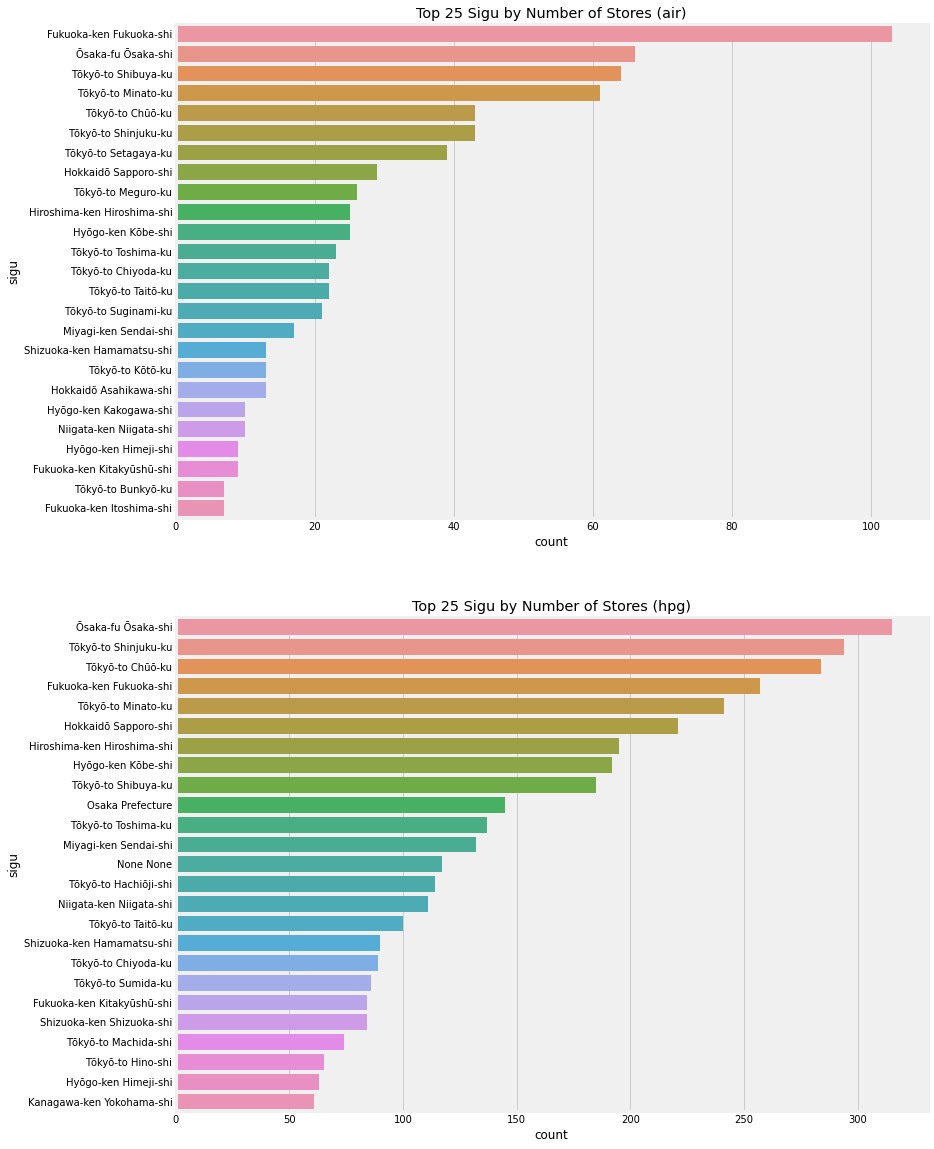

In [39]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12,20))
sns.countplot(y=data['as']['sigu'],
             order=data['as']['sigu'].value_counts().iloc[:25].index, ax=ax1)
sns.countplot(y=data['hs']['sigu'],
             order=data['hs']['sigu'].value_counts().iloc[:25].index, ax=ax2)
ax1.set(title='Top 25 Sigu by Number of Stores (air)')
ax2.set(title='Top 25 Sigu by Number of Stores (hpg)')
plt.show()

### 11) 장르별 요일별 방문자수

In [44]:
# datetime 정보 필요
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])    # 날짜 데이터타입으로 변경
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek              # 요일 컬럼 생성  (정수 0~6)
data['tra']['dow_name'] = data['tra']['visit_date'].dt.day_name()        # 요일명 컬럼 생성 (Monday ~ Sunday)
data['tra']['year'] = data['tra']['visit_date'].dt.year                  # 년도 컬럼 생성
data['tra']['month'] = data['tra']['visit_date'].dt.month                # month 컬럼 생성

data['tra']['visit_date'] = data['tra']['visit_date'].dt.date
data['tra']['year_mth'] = data['tra']['year'].astype(str)+'-'+data['tra']['month'].astype(str)    # 연도-월 형태로 저장

In [45]:
visit = pd.merge(data['tra'],data['as'])
visit.nunique()

air_store_id      829
visit_date        478
visitors          204
dow                 7
dow_name            7
year                2
month              12
year_mth           16
air_genre_name     14
air_area_name     103
latitude          108
longitude         108
dodo                9
sigu               55
dtype: int64

- 장르별, 요일별 방문객 수를 확인해보자.
- 전반적으로 방문자가 많은 장르는 이자카야, 카페, 다이닝 바, 이탈리안/프렌치 정도였다.
- 장르별 점포수 역시 이자카야, 카페, 다이닝바, 이탈리아 순으로 높았기 때문에 점포수에 따른 결과로 볼 수 있다.
- 가라오케, 파티 장르는 금, 토요일에 방문자가 급증했다.

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

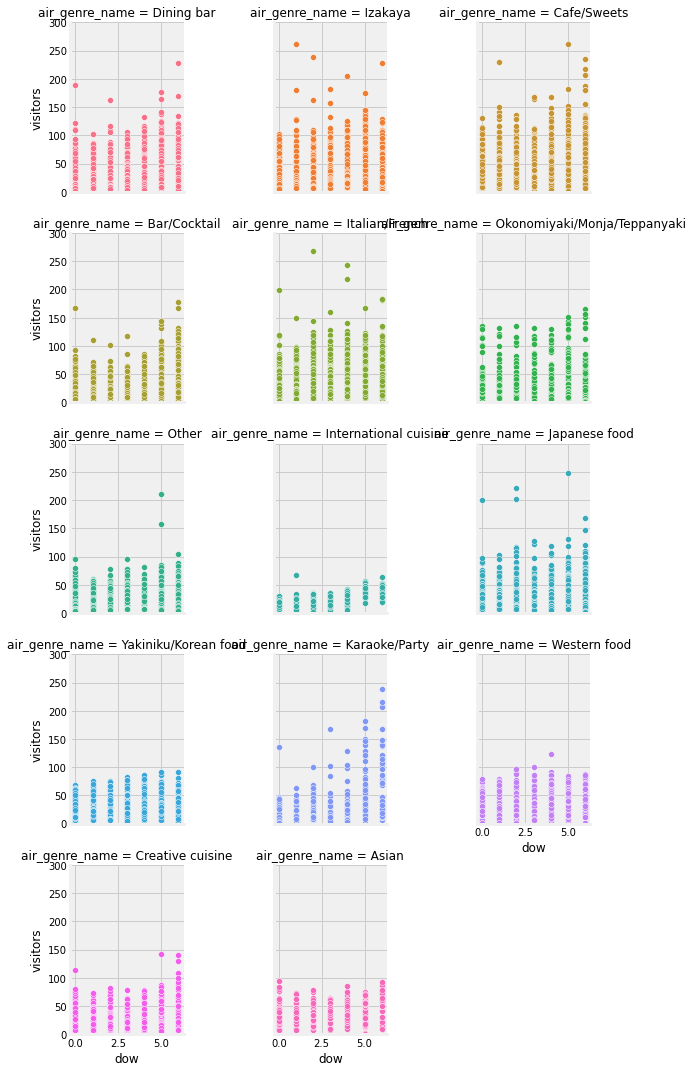

In [46]:
plt.figure(figsize=(15,10))
sns.FacetGrid(visit, col='air_genre_name',hue='air_genre_name',col_wrap=3,
             ylim=(0,300)).map(sns.scatterplot,'dow','visitors')
plt.show()

### 12) 가게 유형별 방문자수
- 한 가게의 일일 방문자수가 877명에 육박하는 등 이상치가 존재한다.
- 가게 유형별 방문자 수의 분포를 보자.

<Figure size 1080x720 with 0 Axes>

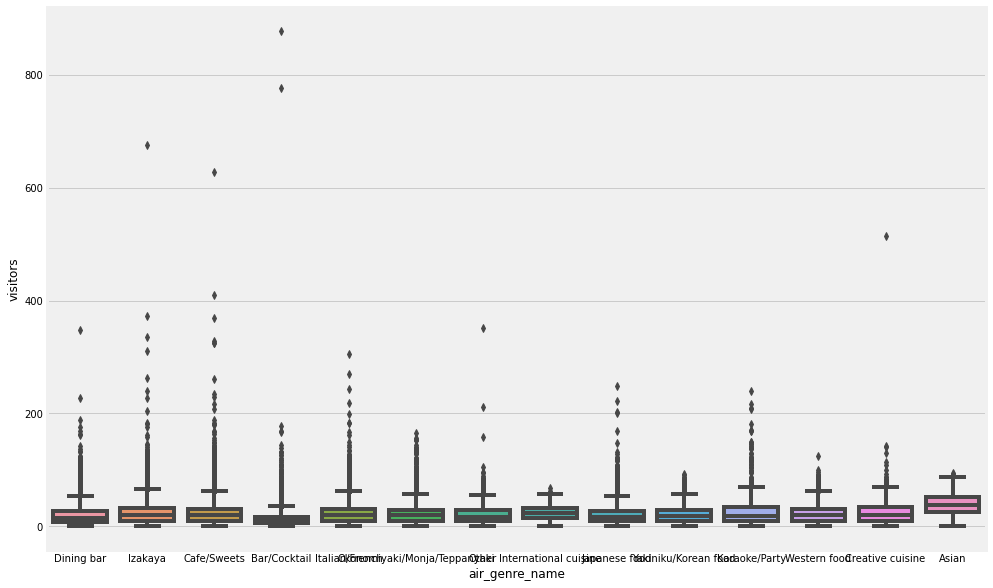

In [47]:
plt.figure(figsize=(15,10))
sns.boxplot(data=visit, x='air_genre_name', y='visitors')
plt.show()

### 13) 위치별 방문자수 

<Figure size 1080x720 with 0 Axes>

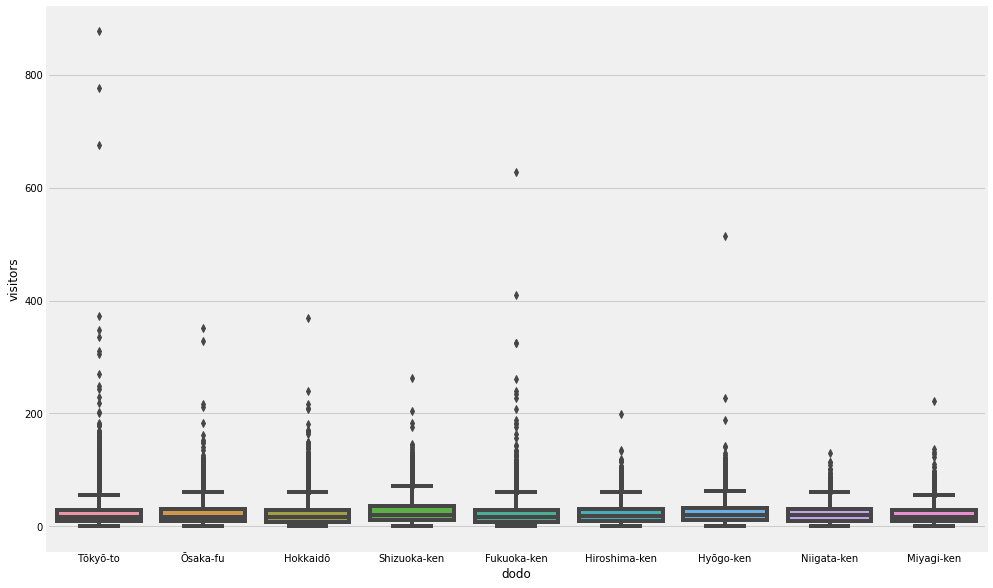

In [48]:
plt.figure(figsize=(15,10))
sns.boxplot(data=visit, x='dodo', y='visitors')
plt.show()

## data6. store_id_relation

### 150개의 겹치는 가게 id

## id 기준으로 store 정보 합치기

### air_store_info에 air_store_id와 일치하는 hpg_store_id 컬럼 대입

In [ ]:
data['as'] = pd.merge(data['as'], data['id'], how='inner', on=['air_store_id'])

### 'hpg_store_id' 기준으로 air_store_info 와 hpg_store_info 합치기

In [ ]:
store_merge = pd.merge(data['as'], data['hs'], how='left', on=['hpg_store_id']) 

### 14) air_store와 hpg_store 결측치 확인

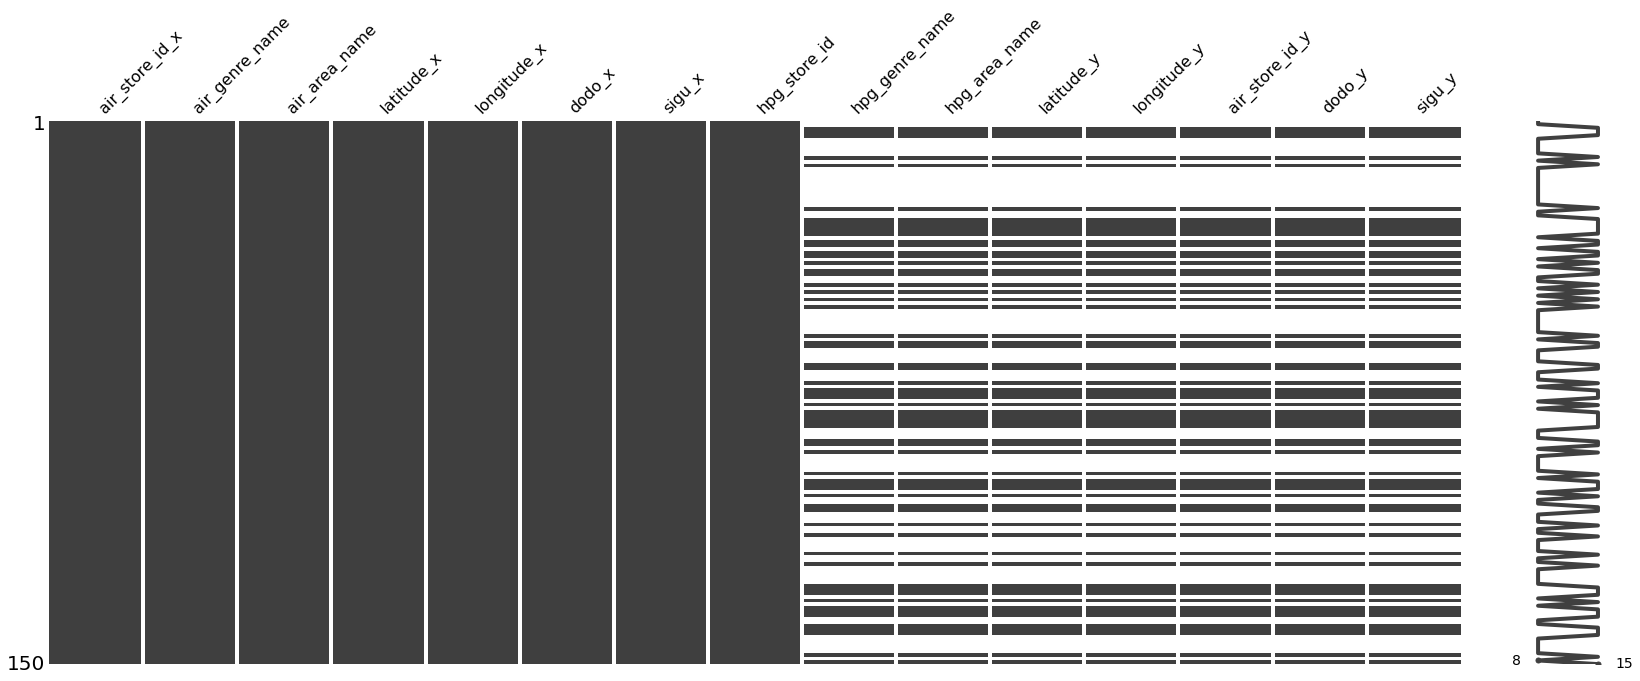

In [ ]:
import missingno as msno

msno.matrix(store_merge)

In [ ]:
store_merge.isnull().sum()

air_store_id_x     0
air_genre_name     0
air_area_name      0
latitude_x         0
longitude_x        0
dodo_x             0
sigu_x             0
hpg_store_id       0
hpg_genre_name    87
hpg_area_name     87
latitude_y        87
longitude_y       87
air_store_id_y    87
dodo_y            87
sigu_y            87
dtype: int64

### => hpg store 정보에 null값이 많이 보임

### 그 중 Null값인 row만 확인

In [ ]:
store_null =store_merge.loc[store_merge["hpg_genre_name"].isnull()]
store_null

,air_store_id_x,air_genre_name,air_area_name,latitude_x,longitude_x,dodo_x,sigu_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,air_store_id_y,dodo_y,sigu_y
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Hyōgo-ken Kōbe-shi,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,air_290e7a57b390f78e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Tōkyō-to,Tōkyō-to Minato-ku,hpg_c5ec63f52e4a7e9e,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,air_938ef91ecdde6878,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tōkyō-to,Tōkyō-to Shibuya-ku,hpg_623477d346cf1822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,air_8e492076a1179383,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,Hiroshima-ken,Hiroshima-ken Hiroshima-shi,hpg_aee92538e1b51d5f,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,air_0867f7bebad6a649,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,Hiroshima-ken,Hiroshima-ken Hiroshima-shi,hpg_caf1082b9f445c7b,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,air_4c727b55acdee495,Creative cuisine,Hyōgo-ken Himeji-shi Yasuda,34.815149,134.685353,Hyōgo-ken,Hyōgo-ken Himeji-shi,hpg_26d20b9f926ff5e9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,air_fea5dc9594450608,Other,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,Shizuoka-ken,Shizuoka-ken Hamamatsu-shi,hpg_6507818140022452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,air_2cee51fa6fdf6c0d,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,Tōkyō-to,Tōkyō-to Shibuya-ku,hpg_113fd6e4fa77800f,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,air_b45b8e456f53942a,Western food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,Hokkaidō,Hokkaidō Sapporo-shi,hpg_a85b37424291216b,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data['hs'].loc[data['hs']['hpg_store_id']=='hpg_9b38b9e13da6da27']

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude,air_store_id,dodo,sigu


In [ ]:
data['as'].loc[data['as']['air_store_id']=='air_7cc17a324ae5c7dc']

,air_store_id,air_genre_name,air_area_name,latitude,longitude,dodo,sigu,hpg_store_id
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,Hyōgo-ken,Hyōgo-ken Kōbe-shi,hpg_9b38b9e13da6da27


### => hpg store 정보가 없는  hpg store id 들이 존재했기 때문..
### => 같은 가게인데도 air_store_info에는 존재하고 hpg_store_info 에는 존재하지 않는 경우가 있다.

# data7. date_info

In [ ]:
# 휴일만
holiday=data['hol'].loc[data['hol']['holiday_flg'] ==1]

In [ ]:
holiday['day_of_week'].value_counts()  # 공휴일인 날의 요일 분포 확인 (공휴일은 월,화인 날이 많았다.)

1    9
4    7
2    5
0    5
3    4
6    3
5    2
Name: day_of_week, dtype: int64

In [ ]:
# 날짜 데이터 타입으로 변경
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])

In [ ]:
# 4월말에서 5월의 데이터를 2016년/2017년 따로 추출
holidays16 = data['hol'][((data['hol']['visit_date'] >'2016-04-15') & (data['hol']['visit_date'] < '2016-06-01'))]
holidays17 = data['hol'][((data['hol']['visit_date'] >'2017-04-15') & (data['hol']['visit_date'] < '2017-06-01'))]

### 15) 공휴일과 아닌 날의 count 비교

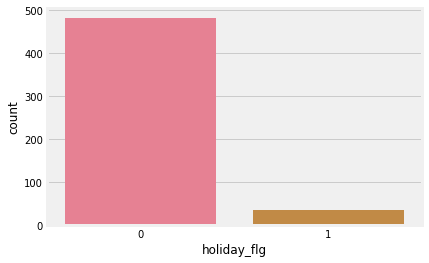

In [ ]:
sns.countplot(x="holiday_flg",data = data['hol']) 

[]

[[]]

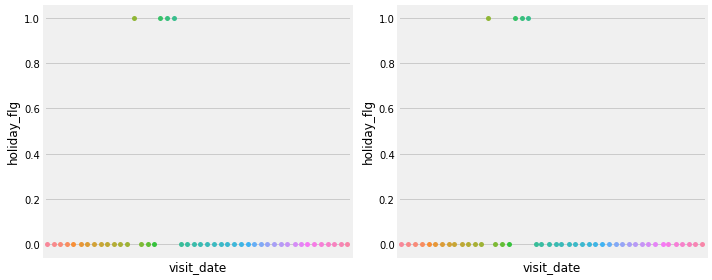

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,4))
plt2 = sns.stripplot(x='visit_date',y='holiday_flg',data=holidays16, ax=ax1)
plt2.set_xticks([])

plt3 = sns.stripplot(x='visit_date',y='holiday_flg',data=holidays17, ax=ax2)
plt3.set(xticks=[])

plt.tight_layout()

- 2016년 4월 말과 5월은 2017년과 휴일이 같다. (4/29, 5/3,5/4,5/5)
- data에서 휴일의 비율은 대략 7%이다.

### 16) 공휴일여부에 따른 방문객평균

In [ ]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])

In [ ]:
tra_hol_merge = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])


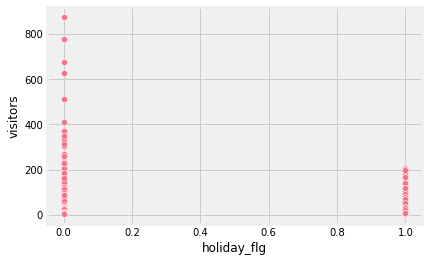

In [ ]:
sns.scatterplot(x='holiday_flg',y='visitors',data=tra_hol_merge)

* 방문객이 400명을 넘는 경우는 공휴일이 아닌 날에 많이 존재함.

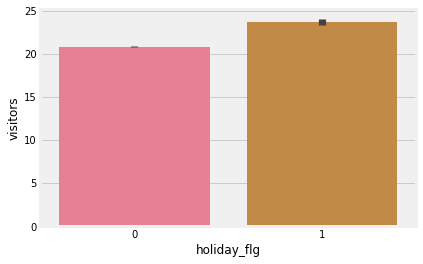

In [ ]:
sns.barplot(x='holiday_flg',y='visitors',data=tra_hol_merge)

* 하지만 평균 방문자수는 공휴일일때 더 많다.

### 공휴일 요일에 따른 방문자평균

In [ ]:
data = {
    'tra': pd.read_csv('/content/drive/MyDrive/data/air_visit_data.csv'),
    'as': pd.read_csv('/content/drive/MyDrive/data/air_store_info.csv'),
    'hs': pd.read_csv('/content/drive/MyDrive/data/hpg_store_info.csv'),
    'ar': pd.read_csv('/content/drive/MyDrive/data/air_reserve.csv'),
    'hr': pd.read_csv('/content/drive/MyDrive/data/hpg_reserve.csv'),
    'id': pd.read_csv('/content/drive/MyDrive/data/store_id_relation.csv'),
    'tes': pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv'),
    'hol': pd.read_csv('/content/drive/MyDrive/data/date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

In [ ]:
tra_holiday_merge = pd.merge(data['tra'],data['hol'], how='left', on=['visit_date'])


### 18) 공휴일과 아닌 날의 요일 별 평균방문자수

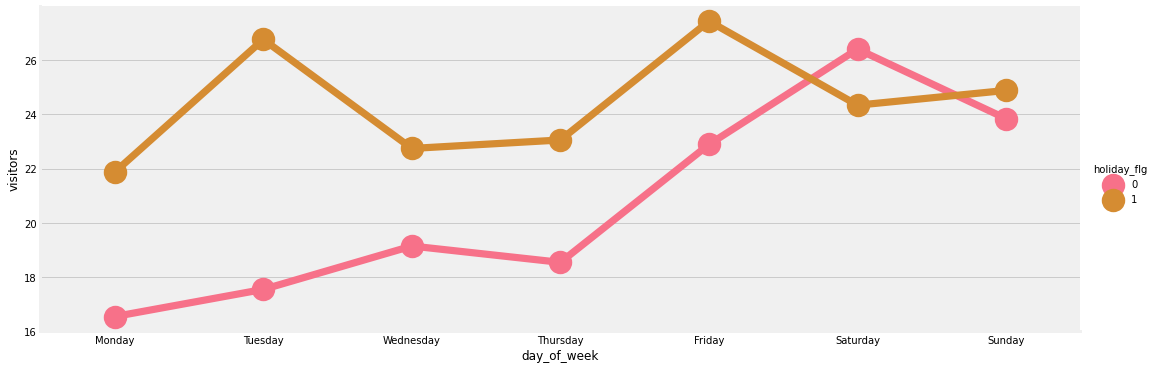

In [ ]:
df_visitors_by_dow = tra_holiday_merge.groupby(['day_of_week','holiday_flg']) \
                             .agg({'visitors':'mean'}) \
                             .reset_index() 
dow = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
df_visitors_by_dow['day_of_week'] = pd.Categorical(df_visitors_by_dow['day_of_week'],categories=dow, ordered=True)
df_visitors_by_dow.sort_values(by='day_of_week', inplace=True)
sns.factorplot(x='day_of_week', y='visitors', data=df_visitors_by_dow, hue='holiday_flg', aspect=3)

* 화요일,금요일이 공휴일일때, 평균방문자수가 제일 많았다.
*  평균방문자 수가 공휴일이 아닌날은 토요일과 일요일에 제일 많다
* 공휴일일때 금요일이 많은 이유는 금토일 연달아 쉬니깐..? 
* 공휴일일때 토요일이 아닌날의 토요일보다 평균방문자수가 적은 이유는 공휴일이니깐 쉬고 싶어서..?

### 19) 공휴일여부에 따른 air 예약자 평균

In [ ]:
ar = pd.read_csv('/content/drive/MyDrive/data/air_reserve.csv')
hol = pd.read_csv('/content/drive/MyDrive/data/date_info.csv'),

ar['visit_datetime'] = pd.to_datetime(ar['visit_datetime'])
ar['visit_datetime'] = ar['visit_datetime'].dt.date
ar

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01,2016-01-01 01:00:00,5
...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31,2017-04-19 16:00:00,10


In [ ]:
ar=ar.rename(columns={
            'visit_datetime': 'visit_date'
        })
ar['visit_date'] = pd.to_datetime(ar['visit_date'])

In [ ]:
ar['visit_date'] = pd.to_datetime(ar['visit_date'])
ar_hol_merge = pd.merge(ar, data['hol'], how='left', on=['visit_date'])
ar['visit_date'] = ar['visit_date'].dt.date

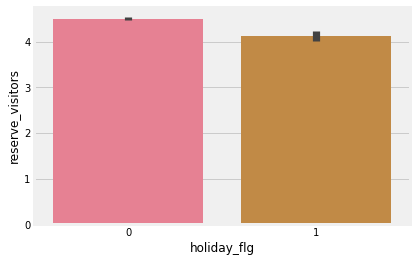

In [ ]:
sns.barplot(x='holiday_flg',y='reserve_visitors',data=ar_hol_merge)

* air 평균 예약자 수는 공휴일이 아닌 날에 더 많다.

### 20) 공휴일여부에 따른 hpg예약자 평균

In [ ]:
hr = pd.read_csv('/content/drive/MyDrive/data/hpg_reserve.csv')

hr['visit_datetime'] = pd.to_datetime(hr['visit_datetime'])
hr['visit_datetime'] = hr['visit_datetime'].dt.date

In [ ]:
hr=hr.rename(columns={
            'visit_datetime': 'visit_date'
        })
hr['visit_date'] = pd.to_datetime(hr['visit_date'])

In [ ]:
hr_hol_merge = pd.merge(hr, data['hol'], how='left', on=['visit_date'])


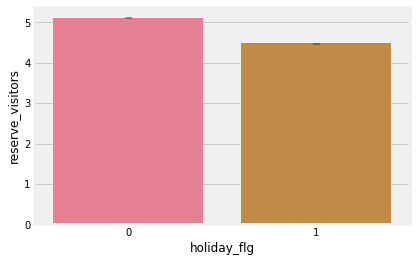

In [ ]:
sns.barplot(x='holiday_flg',y='reserve_visitors',data=hr_hol_merge)

* hpg 평균 예약자 수는 공휴일이 아닌 날에 더 많다.